# 02 - Training

## A - Libraries

In [17]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE

from metaboDGD.util import data, train
from metaboDGD.src import model
import matplotlib.pyplot as plt
import torch
import torch.distributions as D
import umap

## B - Retrieve Dataframe and Cohorts

In [18]:
dir = 'outputs/'
df_fname = 'CombinedDataset_CAMP.csv'
df_exp_fname = 'Exponent_CombinedDataset_CAMP.csv'
cohorts_fname = 'cohorts.pkl'

In [36]:
df = pd.read_csv(dir + df_fname)
df.set_index('Unnamed: 0', inplace=True)
df.index.name = None
df_lbls = df.loc['cohort'].to_list()

df_exp = pd.read_csv(dir + df_exp_fname)
df_exp.set_index('Unnamed: 0', inplace=True)
df_exp.index.name = None

df_log = df.T.drop(columns=['cohort']).astype('float64')

f = open(dir + cohorts_fname, 'rb')
cohorts = pickle.load(f)

In [20]:
## Apply SMOTE so all classes are of size 47
# sm = SMOTE(random_state=100, k_neighbors=2)
# np_exp_smote, df_lbls_smote = sm.fit_resample(df_exp.to_numpy(), np.array(df_lbls))

# ## Update the sample_list for data loaders later
# complete_list = []
# for c in cohorts:
#     sample_list = cohorts[c]['sample_list']

#     if len(sample_list) < 47:
#         smote_sample_list = [c + '_' + str(x+1) for x in range(len(sample_list), 47)]
#         cohorts[c]['sample_list'] += smote_sample_list
#     complete_list += cohorts[c]['sample_list']
        
# df_exp_smote = pd.DataFrame(np_exp_smote, index=complete_list, columns=df_exp.columns.to_list())

## C - Preparing TrainLoader and DGD Model

In [37]:
train_dict = {}
test_dict  = {}

train_lbls = []
test_lbls  = []

plot_counts = {}

In [38]:
train_loader, test_loader = data.create_dataloaders(
    cohorts=cohorts,
    df=df_log,
    batch_size=64
)

BRCA1: 37
ccRCC3: 37
ccRCC4: 19
COAD: 31
GBM: 4
HurthleCC: 2
PDAC: 9
PRAD: 36


In [39]:
dgd_model = model.MetaboDGD(
    latent_dim=10,
    output_dim=df_exp.shape[1],
    dec_hidden_layers_dim=[500, 1000, 1500],
    dec_output_prediction_type='mean',
    dec_output_activation_type='softplus',
    n_comp=8,
    cm_type='diagonal'
)

In [8]:
# sb_prior_sample = dgd_model.gmm.means_prior['dist'].sample(10000)
# log_prob = dgd_model.gmm.means_prior['dist'].log_prob(sb_prior_sample).numpy()
# true_prob = np.exp(log_prob)
# plt.hist(log_prob, bins=50, density=True, edgecolor='black')
# plt.hist(sb_prior_sample[:,0], bins=50, density=True, edgecolor='black')
# plt.hist(sb_prior_sample[:,1], bins=50, density=True, edgecolor='black')
# plt.hist2d(sb_prior_sample[:,0], sb_prior_sample[:,1], bins=50)
# plt.show()

0
--------------------------
Parameter containing:
tensor([[3., 3., 3.,  ..., 3., 3., 3.]], dtype=torch.float64,
       requires_grad=True)
tensor(False)
--------------------------
--------------------------
Parameter containing:
tensor([[3.0001, 3.0001, 2.9999,  ..., 2.9999, 2.9999, 3.0001]],
       dtype=torch.float64, requires_grad=True)
tensor(False)
--------------------------
--------------------------
Parameter containing:
tensor([[3.0002, 3.0002, 3.0000,  ..., 2.9998, 2.9998, 3.0002]],
       dtype=torch.float64, requires_grad=True)
tensor(False)
--------------------------
--------------------------
Parameter containing:
tensor([[3.0003, 3.0003, 3.0000,  ..., 2.9997, 2.9997, 3.0002]],
       dtype=torch.float64, requires_grad=True)
tensor(False)
--------------------------
--------------------------
Parameter containing:
tensor([[3.0003, 3.0003, 3.0000,  ..., 2.9997, 2.9997, 3.0002]],
       dtype=torch.float64, requires_grad=True)
tensor(False)
--------------------------
-------

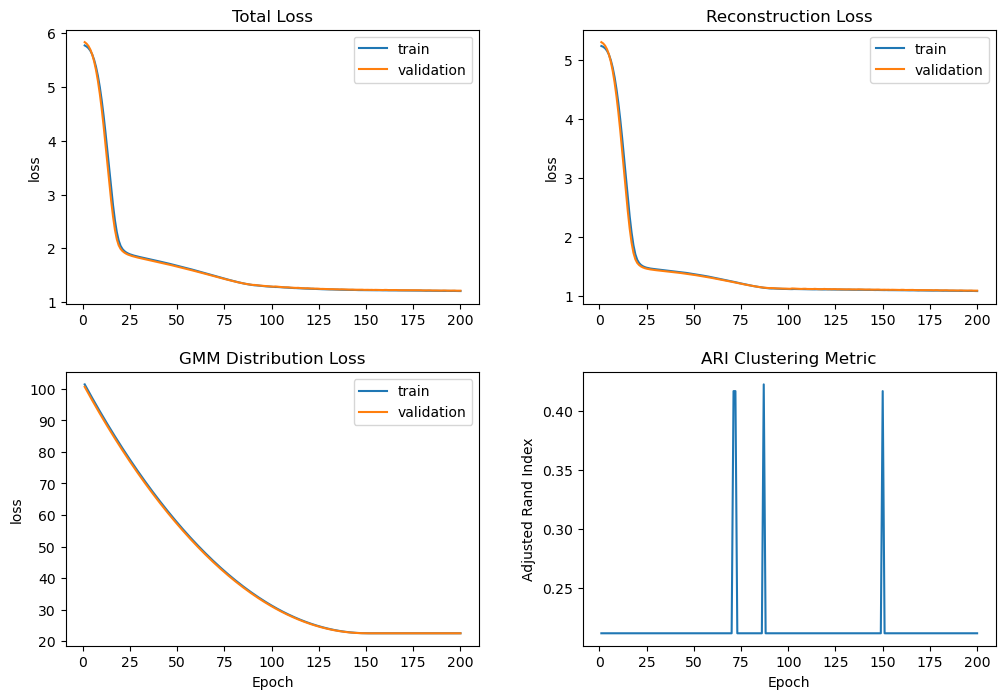

In [40]:
dgd_model, train_rep, test_rep, history = train.train_dgd(
    dgd_model=dgd_model,
    train_loader=train_loader,
    validation_loader=test_loader,
    n_epochs=200,
    lr_schedule_epochs=None,
    lr_schedule=[1e-4, 1e-3, 1e-2],
    optim_betas=[0.5, 0.7],
    wd=1e-5,
)

train.get_history_plot(history)

# OTHER CODE

In [ ]:
print(dgd_model.gmm.weights.detach())
print(dgd_model.gmm.get_mixture_probs().detach())

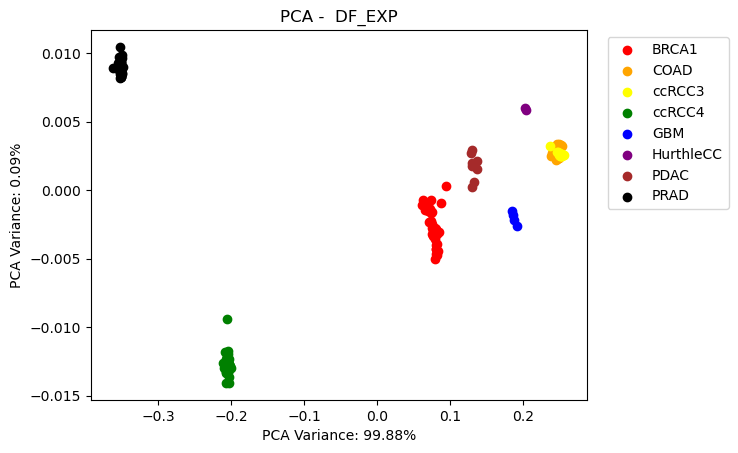

In [41]:
# import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# pca_fit = pca.fit_transform(df_exp.to_numpy())
# pca_fit = pca.fit_transform(df.T.to_numpy()[:,:-1].astype(np.float64))
# pca_fit = pca.fit_transform(np.exp2(df.T.to_numpy()[:,:-1].astype(np.float64)))
pca_fit = pca.fit_transform(train_rep.z.detach().numpy())

# um = umap.UMAP(random_state=100)
# pca_fit = um.fit_transform(df.T.to_numpy()[:, :-1])
# pca_fit = um.fit_transform(df_exp_smote.to_numpy())
# pca_fit = um.fit_transform(train_rep.z.detach().numpy())

fig, ax = plt.subplots()
# ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   , label='BRCA1'    , c='red')
# ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  , label='COAD'     , c='orange')
# ax.scatter(pca_fit[94:118,0]  , pca_fit[94:118,1]  , label='ccRCC3'   , c='yellow')
# ax.scatter(pca_fit[118:157,0] , pca_fit[118:157,1] , label='ccRCC4'   , c='green')
# ax.scatter(pca_fit[157:163,0], pca_fit[157:163,1], label='GBM'      , c='blue')
# ax.scatter(pca_fit[163:166,0], pca_fit[163:166,1], label='HurthleCC', c='purple')
# ax.scatter(pca_fit[166:178,0], pca_fit[166:178,1], label='PDAC'     , c='brown')
# ax.scatter(pca_fit[178:224,0], pca_fit[178:224,1], label='PRAD'     , c='black')

ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]   , label='BRCA1'    , c='red')
ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]  , label='COAD'     , c='orange')
ax.scatter(pca_fit[74:93,0]  , pca_fit[74:93,1]  , label='ccRCC3'   , c='yellow')
ax.scatter(pca_fit[93:124,0] , pca_fit[93:124,1] , label='ccRCC4'   , c='green')
ax.scatter(pca_fit[124:128,0], pca_fit[124:128,1], label='GBM'      , c='blue')
ax.scatter(pca_fit[128:130,0], pca_fit[128:130,1], label='HurthleCC', c='purple')
ax.scatter(pca_fit[130:139,0], pca_fit[130:139,1], label='PDAC'     , c='brown')
ax.scatter(pca_fit[139:175,0], pca_fit[139:175,1], label='PRAD'     , c='black')

# ax.scatter(pca_fit[0:10,0]   , pca_fit[0:10,1]   , label='BRCA1'    , c='red')
# ax.scatter(pca_fit[10:20,0]  , pca_fit[10:20,1]  , label='COAD'     , c='orange')
# ax.scatter(pca_fit[20:25,0]  , pca_fit[20:25,1]  , label='ccRCC3'   , c='yellow')
# ax.scatter(pca_fit[25:33,0] , pca_fit[25:33,1] , label='ccRCC4'   , c='green')
# ax.scatter(pca_fit[33:35,0], pca_fit[33:35,1], label='GBM'      , c='blue')
# ax.scatter(pca_fit[35:36,0], pca_fit[35:36,1], label='HurthleCC', c='purple')
# ax.scatter(pca_fit[36:39,0], pca_fit[36:39,1], label='PDAC'     , c='brown')
# ax.scatter(pca_fit[39:49,0], pca_fit[39:49,1], label='PRAD'     , c='black')




# ax.scatter(pca_fit[0:10,0]   , pca_fit[0:10,1]   , label='BRCA1'    , c='red')
# ax.scatter(pca_fit[10:20,0]  , pca_fit[10:20,1]  , label='COAD'     , c='orange')
# ax.scatter(pca_fit[20:30,0]  , pca_fit[20:30,1]  , label='ccRCC3'   , c='yellow')
# ax.scatter(pca_fit[30:40,0] , pca_fit[30:40,1] , label='ccRCC4'   , c='green')
# ax.scatter(pca_fit[40:50,0], pca_fit[40:50,1], label='GBM'      , c='blue')
# ax.scatter(pca_fit[50:222,0], pca_fit[50:60,1], label='HurthleCC', c='purple')
# ax.scatter(pca_fit[60:70,0], pca_fit[60:70,1], label='PDAC'     , c='brown')
# ax.scatter(pca_fit[70:80,0], pca_fit[70:80,1], label='PRAD'     , c='black')


# ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]     , label='BRCA1'    , c='red')
# ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]    , label='COAD'     , c='orange')
# ax.scatter(pca_fit[74:111,0]  , pca_fit[74:111,1]  , label='ccRCC3'   , c='yellow')
# ax.scatter(pca_fit[111:148,0] , pca_fit[111:148,1] , label='ccRCC4'   , c='green')
# ax.scatter(pca_fit[148:185,0], pca_fit[148:185,1]  , label='GBM'      , c='blue')
# ax.scatter(pca_fit[185:222,0], pca_fit[185:222,1]  , label='HurthleCC', c='purple')
# ax.scatter(pca_fit[222:259,0], pca_fit[222:259,1]  , label='PDAC'     , c='brown')
# ax.scatter(pca_fit[259:296,0], pca_fit[259:296,1]  , label='PRAD'     , c='black')

# ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   , label='BRCA1'    , c='red')
# ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  , label='COAD'     , c='orange')
# ax.scatter(pca_fit[94:141,0]  , pca_fit[94:141,1]  , label='ccRCC3'   , c='yellow')
# ax.scatter(pca_fit[141:188,0] , pca_fit[141:188,1] , label='ccRCC4'   , c='green')
# ax.scatter(pca_fit[188:235,0], pca_fit[188:235,1], label='GBM'      , c='blue')
# ax.scatter(pca_fit[235:282,0], pca_fit[235:282,1], label='HurthleCC', c='purple')
# ax.scatter(pca_fit[282:329,0], pca_fit[282:329,1], label='PDAC'     , c='brown')
# ax.scatter(pca_fit[329:376,0], pca_fit[329:376,1], label='PRAD'     , c='black')


ax.set_xlabel(f'PCA Variance: {(pca.explained_variance_ratio_[0] * 100):.2f}%')
ax.set_ylabel(f'PCA Variance: {(pca.explained_variance_ratio_[1] * 100):.2f}%')
# ax.set_xlabel('UMAP D1')
# ax.set_ylabel('UMAP D2')
ax.set_title('PCA -  DF_EXP')
ax.legend(bbox_to_anchor=(1.30, 1),loc='upper right')

# WANDB Code

In [ ]:
# 873f16d32cf5f8595722bf04c6ead0f9415ad6af
import random

import wandb

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="alfonso_cruz-de-la-salle-university",
    # Set the wandb project where this run will be logged.
    project="my-first-project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'cluster_acc',
        'goal': 'maximize'
    },
    'paramters': {
        'latent_dim': {
            'values': [5, 10, 20, 30],
        },
        'dirichlet_alpha': {
            'values': [0.5, 1, 3, 5],
        },
        'softball_radius': {
            'values': [1, 5, 10],
        },
        'softball_sharpness': {
            'values': [1, 5, 10],
        }
    }
}

"""
sweep_id = wandb.sweep(sweep_config, project='TODO')
wandb.agent(sweep_id, train, count=5)
"""

## WITH SMOTE

In [ ]:
test_cohorts = cohorts.copy()

In [ ]:
from sklearn.decomposition import PCA

X = df_exp.to_numpy()
y = np.array(df_lbls)

sm = SMOTE(random_state=100, k_neighbors=2)
X_new, y_new = sm.fit_resample(X, y)


pca = PCA(n_components=2)
res = pca.fit_transform(X_new)

sum = 0
colors = {
    'BRCA1': 'red',
    'ccRCC3': 'orange',
    'ccRCC4': 'yellow',
    'COAD': 'green',
    'GBM': 'blue',
    'HurthleCC': 'purple',
    'PDAC': 'brown',
    'PRAD': 'black',
}

for i in np.unique(y_new).tolist():
    plt.scatter(res[sum:sum+47, 0], res[sum:sum+47, 1], c=colors[i])
    sum += 47

plt.xlabel(pca.explained_variance_ratio_[0] * 100)
plt.ylabel(pca.explained_variance_ratio_[1] * 100)
plt.title("PCA after SMOTE")